This notebook was run on AWS on a `p3.2xlarge` in approximately 10 hours.

Environment is available as a publically available docker container: `hamelsmu/ml-gpu`

# Build Language Model From Docstrings

The goal is to build a language model using the docstrings, and use that language model to generate an embedding for each docstring.  

In [1]:
from lang_model_utils import lm_vocab, load_lm_vocab, get_emb_batch, train_lang_model
from general_utils import save_file_pickle, load_file_pickle
from pathlib import Path
from fastai.text import *
import torch

source_path = Path('/ds/hamel/code_search_data')

with open(source_path/'train.docstring', 'r') as f:
    trn_raw = f.readlines()

with open(source_path/'valid.docstring', 'r') as f:
    val_raw = f.readlines()

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
trn_raw[:10]

['render this object as a dict of its fields .\n',
 "unset fields so they do n't appear in the message body .\n",
 'runs the daily searcher , queuing selected episodes for search\n',
 'read data from an h5 file in sxs format\n',
 'output the waveform in nrar format .\n',
 'remove the left - whitespace margin of a block of python code .\n',
 'print a line or lines of python which already contain indentation .\n',
 'print a series of lines of python .\n',
 'print a line of python , indenting it according to the current indent level .\n',
 'close this printer , flushing any remaining lines .\n']

## Pre-process data for language model

We will use the class  `build_lm_vocab` to prepare our data for the language model

In [3]:
vocab = lm_vocab(max_vocab=50000,
                 min_freq=15)

# fit the transform on the training data, then transform
trn_flat_idx = vocab.fit_transform_flattened(trn_raw)

Look at the transformed data

In [4]:
trn_flat_idx[:10]

array([  2, 566,  18,  40,  36,   5, 108,   7, 144, 250])

In [5]:
[vocab.itos[x] for x in trn_flat_idx[:10]]

['_xbos_',
 'render',
 'this',
 'object',
 'as',
 'a',
 'dict',
 'of',
 'its',
 'fields']

In [6]:
# apply transform to validation data
val_flat_idx = vocab.transform_flattened(val_raw)

Save files for later use

In [7]:
vocab.save('vocab.cls')
save_file_pickle('trn_flat_idx_list.pkl', trn_flat_idx)
save_file_pickle('val_flat_idx_list.pkl', val_flat_idx) 

## Train Fast.AI Language Model

This model will read in files that were created and train a [fast.ai](https://github.com/fastai/fastai/tree/master/fastai) language model.  This model learns to predict the next word in the sentence using fast.ai's implementation of [AWD LSTM](https://github.com/salesforce/awd-lstm-lm).  

The goal of training this model is to build a general purpose feature extractor for text that can be used in downstream models.  In this case, we will utilize this model to produce embeddings for function docstrings.

In [2]:
vocab = load_lm_vocab('vocab.cls')
trn_flat_idx = load_file_pickle('trn_flat_idx_list.pkl')
val_flat_idx = load_file_pickle('val_flat_idx_list.pkl')

In [3]:
fastai_learner, lang_model = train_lang_model(model_path = '/ds/hamel/code_search_data/outputs/lm_model',
                                              trn_indexed = trn_flat_idx,
                                              val_indexed = val_flat_idx,
                                              vocab_size = vocab.vocab_size,
                                              em_sz= 1200,
                                              nh= 1200,
                                              n_cycle=2,
                                              bs = 80)

epoch      trn_loss   val_loss                                    
    0      3.653804   3.478558  
    1      3.463391   3.252204                                    
    2      3.334521   3.14626                                     
    3      3.384216   3.228185                                    
    4      3.350388   3.110292                                    


/ds/hamel/code_search_data/outputs/lm_model/models/langmodel_best.h5


    5      3.263348   3.034529  



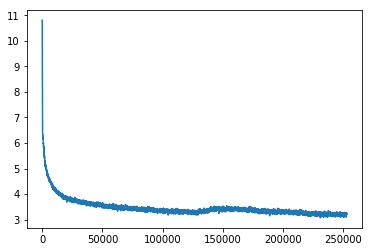

In [4]:
fastai_learner.sched.plot_loss()

Save language model and learner

In [5]:
torch.save(lang_model, '/ds/hamel/code_search_data/outputs/lang_model_gpu.torch')
torch.save(lang_model.cpu(), '/ds/hamel/code_search_data/outputs/lang_model_cpu.torch')
fastai_learner.save('/ds/hamel/code_search_data/outputs/lang_model_learner.fai')

# Load Model and Encode All Docstrings

In [2]:
vocab = load_lm_vocab('vocab.cls')
idx_docs_padded = vocab.transfom(trn_raw + val_raw)
lang_model = torch.load('/ds/hamel/code_search_data/outputs/lang_model_gpu.torch')

In [ ]:
get_emb_batch(lang_model=lang_model, 
              np_array=idx_docs_padded, 
              bs=1000,
              dest_dir='/ds/hamel/code_search_data/outputs/lang_model_emb/')